In [92]:
import pandas as pd 
import numpy as np
from src.download import *
import zipfile 
import glob
from tqdm import tqdm  
import os
from src.files.fasta import FASTAFile 
import src.files.fasta as fasta
import seaborn as sns 
import matplotlib.pyplot as plt
from scipy.stats import entropy 
import re
import subprocess
import math 
from utils import * 
from src.data import * 
from src.stop_codon import *
from src.coevolution import *
from Bio.Seq import Seq

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [117]:
# arf1_df = pd.read_csv('../data/arf1-2.csv', index_col=0) # The duplicates Datarfame contains both aRF1s from the genomes which had duplicate hits. 
# build_stop_codon_dataset(arf1_df, path='../data/arf1-2_with_stop_codons.csv')

arf1_df = pd.read_csv('../data/arf1-2_with_stop_codons.csv', index_col=0) # The duplicates DataFrame contains both aRF1s from the genomes which had duplicate hits. 

stop_codon_genome_metadata_df = pd.read_csv('../data/stop_codon_genome_metadata.csv', index_col=0)
arf1_df['tag_count'] = arf1_df.genome_id.map(stop_codon_genome_metadata_df.groupby('genome_id').TAG.first())
arf1_df['stop_codon_count'] = arf1_df.genome_id.map(stop_codon_genome_metadata_df.groupby('genome_id')['total'].first())
arf1_df['tag_percent'] = arf1_df.tag_count / arf1_df.stop_codon_count
arf1_df['fn_path'] = [f'../data/ncbi/genomes/{genome_id}.fn' for genome_id in arf1_df.genome_id]

if 'genome_gc_percent' not in arf1_df.columns:
    genome_gc_percents = {row.genome_id:FASTAFile().from_fasta(row.fn_path).get_gc_content() for row in arf1_df.drop_duplicates('genome_id').itertuples()}
    arf1_df['genome_gc_percent'] = arf1_df.genome_id.map(genome_gc_percents)

# Going to assume that the release factor with a slightly higher E-value is the aRF1. 
arf1_type_map = dict()
for _, df in arf1_df.groupby('genome_id'):
    df = df.sort_values('e_value')
    arf1_type_map[df.index.values[0]] = 1
    arf1_type_map[df.index.values[1]] = 2
arf1_df['arf1_type'] = arf1_df.index.map(arf1_type_map)

arf1_df.to_csv('../data/arf1-2_with_stop_codons.csv')
FASTAFile().from_df(df=arf1_df[(arf1_df.arf1_type == 2) & (arf1_df.order == 'Methanosarcinales')]).write('../data/arf1-2_only.fa')


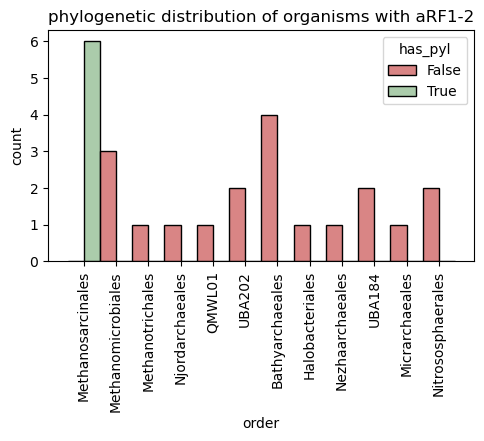

In [94]:
# How to visualize this? Want to compare GC content and overall TAG percent, which can be connected. 
# Basically asking if organisms which use Pyl preferentially have aRF1-2s with a TAG stop codon. 
level = 'order'
fig, ax = plt.subplots(figsize=(5.5, 3))
palette = {True:'darkseagreen', False:'indianred'}
figure_df = arf1_df.drop_duplicates('genome_id')
sns.histplot(figure_df, x=level, hue='has_pyl', multiple='dodge', palette=palette)
ax.set_xticks(np.arange(figure_df[level].nunique()), labels=ax.get_xticklabels(), rotation=90)
ax.set_ylabel('count')
ax.set_title('phylogenetic distribution of organisms with aRF1-2')
plt.show()

# Based on this, I think it makes sense to focus on Methanosarcina.  

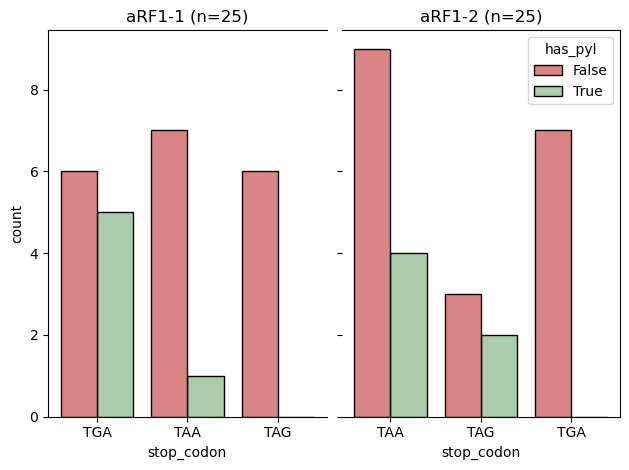

In [95]:
def figure(arf1_df, missing_n_terminus_ids:list=[], stat:str='count'):

    fig, (ax_a, ax_b) = plt.subplots(ncols=2, sharey=True)
    figure_df = arf1_df.copy()
    figure_df = figure_df[~figure_df.index.isin(missing_n_terminus_ids)].copy()

    palette = {True:'darkseagreen', False:'indianred'}
    # order = ['TAG', 'TGA', 'TAA']
    kwargs = {'multiple':'dodge', 'stat':stat, 'shrink':0.8, 'common_norm':False, 'palette':palette} # , 'order':order}
    sns.histplot(figure_df[figure_df.arf1_type == 1], ax=ax_a, x='stop_codon', hue='has_pyl', legend=False, **kwargs)
    sns.histplot(figure_df[figure_df.arf1_type == 2], ax=ax_b, x='stop_codon', legend=True, hue='has_pyl', **kwargs)

    ax_a.spines.get('right').set_visible(False)
    ax_b.spines.get('left').set_visible(False)
    ax_b.set_ylabel('')
    # ax_b.set_yticks([])
    ax_a.set_ylabel(stat)

    ax_a.set_title(f'aRF1-1 (n={(figure_df.arf1_type == 1).sum()})')
    ax_b.set_title(f'aRF1-2 (n={(figure_df.arf1_type == 2).sum()})')

    fig.tight_layout()
    plt.show()

figure(arf1_df = pd.read_csv('../data/arf1-2_with_stop_codons.csv', index_col=0))
# Worth noting that Pyl+ genomes tend to have lower GC content, which means they should be biased towards 
# TAA stop codons. That makes this especially weird. 

In [96]:
arf1_df = arf1_df[arf1_df.order == 'Methanosarcinales'].copy()
FASTAFile().from_df(arf1_df).write('../data/arf1-2.fa') # Decided to only align the Methanosarcina. 

index, alignment = load_msa('../data/arf1-2.afa', ids=arf1_df.index.values, conservation_threshold=0.4)
alignment_df = pd.DataFrame(alignment, index=index)
alignment_df['arf1_type'] = arf1_df.arf1_type

In [97]:
seq = ''.join(alignment[0])
domain_boundaries = get_domain_boundaries(seq)

get_domain_boundaries: NIKS boundaries 55-59.
get_domain_boundaries: YxCxxxF boundaries 119-126.
get_domain_boundaries: GTS boundaries 23-26.


In [108]:
# Seems like there might be a lot of gaps... in what positions do most of the aRF1-2s have gaps?
arf12_alignment_df = alignment_df[alignment_df.arf1_type == 2].copy()
arf12_alignment_df = arf12_alignment_df[[col for col in arf12_alignment_df.columns if (type(col) == int)]].copy()
gap_positions = np.where([(np.count_nonzero(col == '-') / len(col)) > 0.4 for col in arf12_alignment_df.values.T])[0]
print('Positions where > 40% of the aRF1-2s have gaps:', ', '.join(gap_positions.astype(str)))

is_missing_n_terminus = lambda row : np.all(row.values[:40] == '-')
arf12_alignment_df['missing_n_terminus'] = arf12_alignment_df.apply(is_missing_n_terminus, axis=1)
missing_n_terminus_ids = arf12_alignment_df[arf12_alignment_df.missing_n_terminus].index.values

# figure(pd.read_csv('../data/arf1-2_with_stop_codons.csv', index_col=0), missing_n_terminus_ids=missing_n_terminus_ids)

Positions where > 40% of the aRF1-2s have gaps: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45


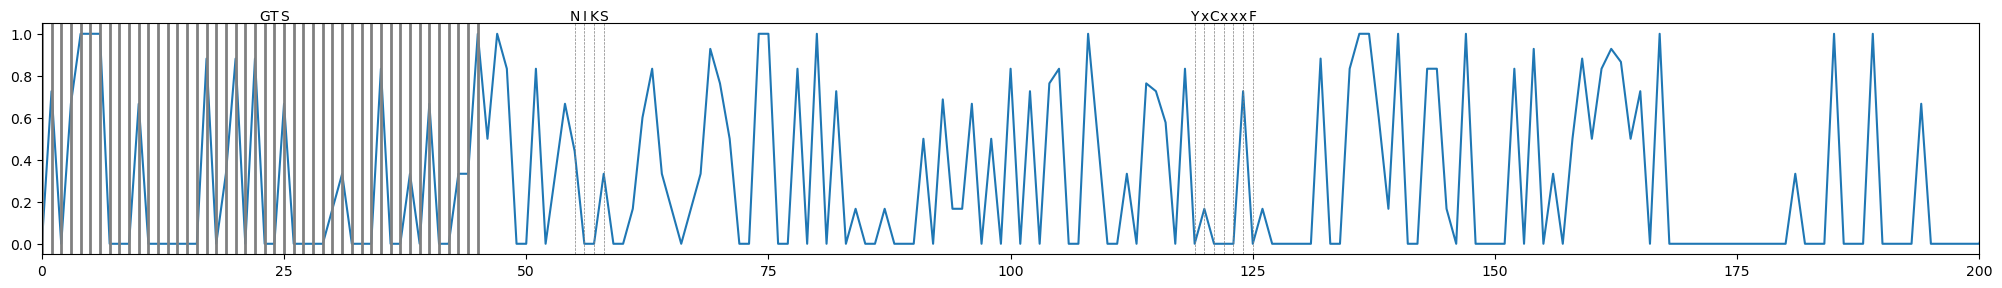

In [99]:
def annotate_residues(annotations:dict, ax=None, lines_only:bool=False):
    for seq, (start, stop) in annotations.items():
        positions = np.arange(start, stop)
        for x, aa in zip(positions, list(seq)):
            if not lines_only:
                ax.text(x, ax.get_ylim()[-1], aa, ha='center', va='bottom')
            ax.axvline(x, ls='--', lw=0.5, color='gray')

fig, ax = plt.subplots(figsize=(25, 3))
scores = get_scores(alignment_df, group_by='arf1_type')
sns.lineplot(x=np.arange(len(scores)), y=scores)
ax.set_xlim(xmin=0, xmax=200)

for position in gap_positions:
    ax.axvline(position, color='gray', lw=2)

annotate_residues(domain_boundaries, ax=ax)

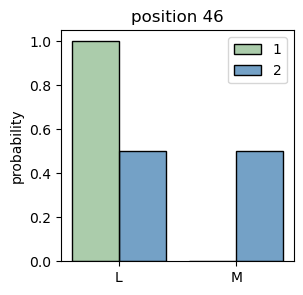

In [100]:
# def plot_residue_counts(figure_df:pd.DataFrame, position:int=None, palette=None, ax=None, hue:str=None, stat:str='probability'):
fig, ax = plt.subplots(figsize=(3, 3))
palette = {1:'darkseagreen', 2:'steelblue'}
plot_residue_counts(alignment_df, position=46, palette=palette, hue='arf1_type', ax=ax)
# L to M is not much of a change, both are nonpolar, M is slightly larger. This is possibly a Prodigal error, 
# but this implies that there is something weird about the codon usage or GC content in the N-terminal region.

In [116]:
get_reverse_complement = lambda seq : str(Seq(seq).reverse_complement())

start_codons = ['ATG', 'TTG', 'GTG']
stop_codons = ['TAA', 'TGA'] # Don't treat TAG as a stop codon. 

def get_nt_seq(start:int=None, stop:int=None, strand:int=None, fn_path:str=None, contig_id:str=None, adjust_start:bool=True, **kwargs):
    fn_file = FASTAFile().from_fasta(fn_path)
    contig = fn_file.seqs[fn_file.ids == contig_id][0] # Extract the contig sequence. 
    nt_seq = contig[start - 1:stop] if adjust_start else contig[start:stop] # Sometimes the start is already adjusted.
    nt_seq = get_reverse_complement(nt_seq) if (strand == -1) else nt_seq
    # print(len(nt_seq) / 3)
    return nt_seq 

def get_aa_seq(nt_seq:str):
    assert (len(nt_seq) % 3) == 0, f'get_aa_seq: Nucleotide sequence length should be divisible by three, but got remainder {len(nt_seq) % 3}'
    seq = str(Seq(nt_seq).translate(cds=False, stop_symbol='*')) # Don't require stop in order to support TAG reassignment.
    seq = seq[:-1] # Remove the terminal stop symbol. 
    # seq = seq.replace('*', 'X') # Replace other stop characters with X. 
    return seq

def get_codons(nt_seq):
    codons = np.array([nt_seq[i:i + 3] for i in range(0, len(nt_seq), 3)])
    assert len(codons) == (len(nt_seq) / 3), f'get_codons: Number of codons should be equal to the length of the sequence divided by three. Expected {len(nt_seq) / 3}, got {len(codons)}.'
    return codons 

def get_internal_tag(nt_seq):
    codons = get_codons(nt_seq)
    return 0 if ('TAG' not in codons) else ', '.join(np.where(codons == 'TAG')[0].astype(str))

def get_pyl_residues(row):
    # Label the Pyl residues to distinguish these from other stop codons. 
    codons = get_codons(row.nt_seq)[:-1] # Don't consider the terminal stop codon. 
    seq = np.array(list(row.seq)) # The amino acid sequence. 
    if 'TAG' in codons:
        pyl_idxs = np.where(codons == 'TAG')[0]
        print(f'get_pyl_residues: Found {len(pyl_idxs)} Pyls in the sequence.')
        seq[pyl_idxs] = 'O'
    seq = ''.join(seq)
    return seq 


# Trying to detect a valid start codon does not seem to be working, so instead opted to force N-terminal extension (ignoring all in-frame
# stop codons and eliminating the requirement for an in-frame stop). 
def get_five_prime_extension(row, extension_length:int=55, translate:bool=True): # Should have already checked that the sequence is extendable. 
    return row.upstream_nt_seq[-3 * extension_length:] + row.nt_seq

# def get_three_prime_extension

ext_arf1_df = parse_prodigal_description(arf1_df).copy()
# #  This one seems to have been erroneously N-terminally extended (should start at Met36)
# ext_arf1_df.loc['CP009508.1_4664', 'seq'] = ext_arf1_df.loc['CP009508.1_4664', 'seq'][35:] 
# ext_arf1_df.loc['CP009508.1_4664', 'start'] = ext_arf1_df.loc['CP009508.1_4664', 'start'] + (35 * 3) 
# # print((ext_arf1_df.stop - ext_arf1_df.start).max() // 3)

ext_arf1_df['fn_path'] = [os.path.join('../data/ncbi/genomes', f'{genome_id}.fn') for genome_id in ext_arf1_df.genome_id]
ext_arf1_df['fa_path'] = [os.path.join('../data/prodigal', f'{genome_id}.fa') for genome_id in ext_arf1_df.genome_id]

extend_to_length = 450 # In amino acids. 
ext_arf1_df['extension_length'] = 3 * (extend_to_length - ext_arf1_df.seq.apply(len)) # N-terminally extend all sequences to the same length. 

# ext_arf1_df['start_delta'] = np.where(ext_arf1_df.strand == 1, -ext_arf1_df.extension_length, 0)
# ext_arf1_df['stop_delta'] = np.where(ext_arf1_df.strand == -1, ext_arf1_df.extension_length, 0)

ext_arf1_df['start_delta'] = np.where(ext_arf1_df.strand == 1, -ext_arf1_df.extension_length, -60)
ext_arf1_df['stop_delta'] = np.where(ext_arf1_df.strand == -1, ext_arf1_df.extension_length, 60)

ext_arf1_df['start'] = ext_arf1_df.start + ext_arf1_df.start_delta 
ext_arf1_df['stop'] = ext_arf1_df.stop + ext_arf1_df.stop_delta 
ext_arf1_df['nt_seq'] = [get_nt_seq(**row._asdict()) for row in ext_arf1_df.itertuples()]
ext_arf1_df['seq'] = ext_arf1_df.nt_seq.apply(get_aa_seq) # get_aa_seq already removes the terminal *. 
ext_arf1_df['seq'] = ext_arf1_df.apply(get_pyl_residues, axis=1)
ext_arf1_df.index = [f'{row.arf1_type}:{row.Index}' for row in ext_arf1_df.itertuples()]
# arf1_df = parse_prodigal_description(arf1_df)
# arf1_df['fn_path'] = [os.path.join('../data/ncbi/genomes', f'{genome_id}.fn') for genome_id in arf1_df.genome_id]
# arf1_df['seq'] = arf1_df.seq.replace('*', '') # Remove the terminating * character.

# # ext_arf1_df = pd.concat([arf1_df.loc[missing_n_terminus_ids].copy().assign(frame=i) for i in range(3)])
# ext_arf1_df = arf1_df.loc[missing_n_terminus_ids].copy().assign(frame=0)
# ext_arf1_df['original_length'] = ext_arf1_df.seq.apply(len)
# # ext_arf1_df['extendable'] = ext_arf1_df.apply(is_extendable, axis=1)
# # ext_arf1_df = ext_arf1_df[ext_arf1_df.extendable].copy()
# ext_arf1_df['nt_seq'] = ext_arf1_df.apply(get_five_prime_extension, axis=1)
# ext_arf1_df['seq'] = ext_arf1_df.nt_seq.apply(get_aa_seq)
# ext_arf1_df['length'] = ext_arf1_df.seq.apply(len)
# ext_arf1_df['extension_length'] = ext_arf1_df.seq.apply(len) - ext_arf1_df.original_length
# ext_arf1_df.index = [f'*{id_}' for id_ in ext_arf1_df.index]

FASTAFile().from_df(ext_arf1_df).write('../data/arf1-2_extended.fa')
FASTAFile().from_df(ext_arf1_df.drop(columns=['seq']).rename(columns={'nt_seq':'seq'})).write('../data/arf1-2_extended.fn')



get_pyl_residues: Found 1 Pyls in the sequence.
get_pyl_residues: Found 1 Pyls in the sequence.
get_pyl_residues: Found 1 Pyls in the sequence.
get_pyl_residues: Found 1 Pyls in the sequence.
get_pyl_residues: Found 1 Pyls in the sequence.
get_pyl_residues: Found 2 Pyls in the sequence.
get_pyl_residues: Found 2 Pyls in the sequence.
get_pyl_residues: Found 3 Pyls in the sequence.


In [102]:
ext_arf1_df.extension_length // 3

1:DAOUSW010000023.1_22     34
1:DAQQ01000172.1_2         34
1:CALCXE010000184.1_2      34
1:JAEWQJ010000043.1_49     34
1:JAENZL010000001.1_102    34
1:MDTP02000004.1_23        34
2:MDTP02000180.1_3         34
2:JAENZL010000016.1_1      34
2:DAOUSW010000083.1_1      34
2:JAEWQJ010000002.1_74     80
2:DAQQ01000051.1_2         80
2:CALCXE010000213.1_9      80
Name: extension_length, dtype: int64

In [109]:
# Is there anything to the left of the release factors which could explain the conservation?

arf1_df[['length', 'query_length', 'target_length', 'query_coords', 'target_coords']]
window_size = 100 # Nucleotides. 

for row in ext_arf1_df.itertuples():
    fasta_df = FASTAFile().from_fasta(row.fa_path).to_df(parse_description=True)
    fasta_df = fasta_df[fasta_df.contig_id == row.contig_id].copy()

    # start, stop = row.start - window_size, row.start
    # Checking for other predicted proteins that overlap the extended N-terminus.
    overlap_region = row.start - window_size, row.stop + window_size # Looking in a region extended __ bp at either terminus. 
    fasta_df = fasta_df[~((fasta_df.stop < overlap_region[0]) | (fasta_df.start > overlap_region[-1]))].copy()
    fasta_df = fasta_df[fasta_df.index != row.Index.split(':')[-1]].copy()
    if len(fasta_df) > 0:
        print(f'Overlapping proteins for sequence {row.Index} (aRF1 type {row.arf1_type}): {''.join(fasta_df.index.values)}')

# Seems like essentially no overlapping ORFs nearby. 

# Worth noting that in the non-truncated cases, the entire span of the query is covered. 
# The alignment to the target suggests possible widespread N-terminal extension (by 8 residues at the 5' terminus and 
# maybe 3 residues at the 3' terminus). 

Overlapping proteins for sequence 1:JAENZL010000001.1_102 (aRF1 type 1): JAENZL010000001.1_103


In [104]:
# Dipti's theory is that aRF1-2 might not be doing anything in vivo because the selected stop codon is incorrect. 
# Based on the HMM hits, this doesn't really make sense, but would be interesting to see if there are additional stop codons in the downstream region. 

In [105]:
# def get_five_prime_extension(row, min_extension_length:int=0): # Should have already checked that the sequence is extendable. 

#     codons = get_codons(row.upstream_nt_seq)
#     # Get the indices of the rightmost stop codon and start codon. 
#     # print(np.where(np.isin(codons, stop_codons))[0])

#     # if not ignore_stops:
#     #     stop_codon_idx =  np.where(np.isin(codons, stop_codons))[0][-1] if np.any(np.isin(codons, stop_codons)) else 0
#     #     codons = codons[stop_codon_idx + 1:] # Get the codons following the rightmost stop codon. 

#     start_codon_idxs =  np.where(np.isin(codons, start_codons))[0] if np.any(np.isin(codons, start_codons)) else None
#     if start_codon_idxs is None:
#         print(f'get_five_prime_extension: No alternate start codon found for {row.name}.')
#         return row.seq

#     # The number of codons in the upstream region minus the start codon index is the length of the extension.
#     print(len(codons) - start_codon_idxs) 
#     print(start_codon_idxs)
#     start_codon_idxs = start_codon_idxs[(len(codons) - start_codon_idxs) > min_extension_length]
#     start_codon_idx = start_codon_idxs[-1] # Get the rightmost stop codon that meets the minimum extension length requirement. 
#     nt_seq = ''.join(codons[start_codon_idx:]) + row.nt_seq
    
#     return get_aa_seq(nt_seq)

# def is_extendable(row, stop_codons=stop_codons, start_codons=start_codons):
#     codons = get_codons(row.upstream_nt_seq)
#     # Get the indices of the rightmost stop codon and start codon. 
#     stop_codon_idx =  np.where(np.isin(codons, stop_codons))[0][-1] if np.any(np.isin(codons, stop_codons)) else 0
#     start_codon_idx =  np.where(np.isin(codons, start_codons))[0][-1] if np.any(np.isin(codons, start_codons)) else None
    
#     if (start_codon_idx is None) or (stop_codon_idx > start_codon_idx):
#         return False 
#     else:
#         return True


# def get_upstream_nt_seq(row) # , n_base_pairs:int=300):
#     # Make sure the shift start to be zero-indexed. 
#     start, stop, strand, fn_path, contig_id = row.start - 1, row.stop, row.strand, row.fn_path, row.contig_id
#     frame = getattr(row, 'frame', 0)
#     n_base_pairs = row.extension_length * 3 # Get the number of nucleotides 

#     if (strand == 1):
#         stop = start - frame
#         start = stop - n_base_pairs 
#     elif (strand == -1):
#         start = stop + frame 
#         stop = start + n_base_pairs 
    
#     upstream_nt_seq = get_nt_seq(start=start, stop=stop, fn_path=fn_path, strand=strand, contig_id=contig_id, adjust_start=False) # Start index has already been shifted.
#     assert (stop - start) == n_base_pairs, f'get_upstream_nt_seq: Something is wrong with the stop and start indices, stop - start is {stop - start}, but expected {n_base_pairs}.'
#     assert (len(upstream_nt_seq) % 3) == 0, f'get_upstream_nt_seq: Expected nucleotide sequence to be divisible by three, but got remainder {len(upstream_nt_seq) % 3}'
#     return upstream_nt_seq 

In [106]:
f = open('../data/arf12_n_terminus.fn', 'w')

for row in arf1_df[~arf1_df.index.isin(missing_n_terminus_ids)].itertuples():
    f.write((f'>{row.Index}_1..150')) # Get the first 150 nucleotides.
    print(row.nt_seq[:150]) # Get the first 150 residues of the sequence for the non-N-terminally truncated sequences.
for row in ext_arf1_df.itertuples():
    print(f'>*{row.Index}_-150..1')
    print(row.upstream_nt_seq[-150:])

AttributeError: 'Pandas' object has no attribute 'nt_seq'

In [ ]:
arf1_df_[arf1_df_.missing_n_terminus]


NameError: name 'arf1_df_' is not defined

In [ ]:
arf1_df_[arf1_df_.missing_n_terminus]
arf1_df_.loc[['CP008746.1_1821', 'CP009503.1_3630']]

,start,stop,strand,ID,partial,start_type,rbs_motif,rbs_spacer,gc_content,seq,missing_n_terminus,genome_id,contig_id,fn_path,extended_nt_seq,extended_seq,extension_length,internal_tag
CP008746.1_1821,2192513,2193622,-1,1_1821,00,TTG,none,None,0.407,MR*GEVETAEYCTYEKYVLKKKLEILKNKSGKSTELISLYIPPNKQ...,True,GCA_001027005.1,CP008746.1,../data/ncbi/genomes/GCA_001027005.1.fn,ATGAGATAGGGGGAAGTTGAAACGGCTGAATACTGTACATATGAAA...,MR*GEVETAEYCTYEKYVLKKKLEILKNKSGKSTELISLYIPPNKQ...,53,"2, 422"
CP009503.1_3630,4091038,4092285,-1,1_3630,00,ATG,GGA/GAG/AGG,5-10bp,0.469,MTEQSAHEKYEFKKKLEGLRNKRGRSTELISLYIPADKQIFDVTNQ...,False,GCA_000969965.1,CP009503.1,../data/ncbi/genomes/GCA_000969965.1.fn,ATGACTGAACAATCCGCACACGAAAAGTATGAATTTAAAAAGAAGC...,MTEQSAHEKYEFKKKLEGLRNKRGRSTELISLYIPADKQIFDVTNQ...,0,0


In [ ]:
seq = ''.join(alignment[0]) # The first entry in the alignment has the canonical NIKS domain and YXCXXXF.

niks_match = re.search('NIKS', seq)
# ycf_match = re.search(ycf_domain, seq, flags=re.DOTALL)

start, stop = niks_match.start(), niks_match.end()

In [ ]:
# domain = 'niks'

# def figure(arf1_df:pd.DataFrame, domain:str='niks'):
#     fig, (ax_top, ax_bottom) = get_split_figure((0, 500), (2200, 2400))

#     # figure_df = pd.DataFrame(index=pd.Series(np.arange(1, 4), name='num_arf1'))
#     figure_df = list()

#     categories = ['pyl', f'pyl_{domain}', 'no_pyl', f'no_pyl_{domain}']
#     masks = [(arf1_df.has_pyl), (arf1_df.has_pyl & arf1_df[f'has_{domain}_domain']), (~arf1_df.has_pyl), (~arf1_df.has_pyl & arf1_df[f'has_{domain}_domain'])]
#     palette = {'pyl':'darkseagreen', f'pyl_{domain}':'seagreen', 'no_pyl':'indianred', f'no_pyl_{domain}':'firebrick'}

#     for category, mask in zip(categories, masks):
#         num_arf1_counts = arf1_df[mask].groupby('genome_id').size().value_counts()
#         figure_df += [{'num_arf1':n, 'count':num_arf1_counts.loc[n], 'category':category} for n in num_arf1_counts.index]
#     figure_df = pd.DataFrame(figure_df)
#     figure_df = figure_df[figure_df.num_arf1 < 4].copy()

#     # How many cases of Pyl-containing organisms with two ARF-1s and only one with a NIKS domain?
#     arf1_counts = arf1_df.groupby('genome_id').size()
#     genome_ids_multiple_arf1s = arf1_counts[arf1_counts > 1].index.values.tolist()
#     # no_pyl_genome_ids_multiple_arf1s = arf1_counts[(arf1_counts > 1) & (arf1_counts.index.isin(no_pyl_genome_ids))].index.values.tolist()

#     sns.barplot(figure_df, x='num_arf1', y='count', hue='category', edgecolor='black', ax=ax_top, palette=palette) #, binsize=0.2)
#     sns.barplot(figure_df, x='num_arf1', y='count', hue='category', edgecolor='black', ax=ax_bottom, legend=False, palette=palette) #, binsize=0.2)
#     ax_top.set_ylabel('')
#     ax_top.get_legend().set_title('')
#     ax_bottom.set_xlabel('num. aRF-1')

#     plt.show()
#     return genome_ids_multiple_arf1s

# genome_ids_multiple_arf1s = figure(arf1_df)
# arf1_df['has_multiple_arf1'] = arf1_df.genome_id.isin(genome_ids_multiple_arf1s)


# # It's concerning that some of the non-Pyl organisms have multiple aRF-1 genes. None of the non-Pyl genomes with multiple
# # aRF-1s have a lot of contamination, so it's possible that they have Pyl machinery that were missed by the HMMs.